# Regression Workshop

* 가락시장의 고구마에 대한 일일 특 등급 가격을 예측하고자 합니다.  
* 일별 농산물 가격정보와 일별 입고정보만을 가지고 데이터프레임을 구성하고 예측을 시도해 봅시다.


## 00 환경준비

### 01.Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### 02.Data Loading

In [2]:
g_in = pd.read_csv('https://raw.githubusercontent.com/DA4BAM/dataset/master/garak_market_in.CSV')
g_price = pd.read_csv('https://raw.githubusercontent.com/DA4BAM/dataset/master/garak_market_price.CSV')

g_price['Date'] = pd.to_datetime(g_price['Date'], format='%Y%m%d')
g_in['Date'] = pd.to_datetime(g_in['Date'], format='%Y%m%d')

### 가설수립
* 고구마 가격에 영향을 주는 요소가 무엇일까요?
* 적어도 3가지 적어 봅시다.

In [ ]:
# 1 : 최근 1주일의 평균가격

In [ ]:
# 2 : 최근 1주일의 입고량

In [ ]:
# 3 : 전전날 대비 전날 가격 증감

### 23.Feature Engineering

위에서 수립한 가설을 바탕으로 데이터 프레임을 만들어 봅시다.


In [6]:
# g_price 에서 고구마이면서 0등급 상품에 대해서 별도 데이터프레임으로 저장합시다.
# 날짜, Price, KG
g_price['Unit_Price'] = g_price['Price'] / g_price['KG']
g_price2 = g_price.loc[(g_price['ProductName']=='고구마') & (g_price['Grade']==0), ['Date','ProductName','Unit_Price']]
g_price2.head()

,Date,ProductName,Unit_Price
0,2019-01-03,고구마,4445.0
35,2019-01-04,고구마,4844.7
70,2019-01-05,고구마,4308.5
105,2019-01-07,고구마,5174.4
140,2019-01-08,고구마,4752.3


다음의 변수를 추가합시다.

In [ ]:
# unit_price  = Price / KG
# y : unit_price


In [7]:
# 전날 가격 .shift()
g_price2['Price_lag'] = g_price2['Unit_Price'].shift()
g_price2.head()

,Date,ProductName,Unit_Price,Price_lag
0,2019-01-03,고구마,4445.0,NaN
35,2019-01-04,고구마,4844.7,4445.0
70,2019-01-05,고구마,4308.5,4844.7
105,2019-01-07,고구마,5174.4,4308.5
140,2019-01-08,고구마,4752.3,5174.4


In [13]:
# 전날 입고량, .shift(), pd.merge()
# g_in, price df ==> pd.merge()
g_price3 = pd.merge(g_price2, g_in)
g_price3['in_ton_lag'] = g_price3['in_ton'].shift()
g_price3.head()

,Date,ProductName,Unit_Price,Price_lag,ProductID,in_ton,in_ton_lag
0,2019-01-03,고구마,4445.0,NaN,15100,148,NaN
1,2019-01-04,고구마,4844.7,4445.0,15100,138,148.0
2,2019-01-05,고구마,4308.5,4844.7,15100,106,138.0
3,2019-01-07,고구마,5174.4,4308.5,15100,174,106.0
4,2019-01-08,고구마,4752.3,5174.4,15100,126,174.0


In [14]:
# 요일 .dt.dayofweek
g_price3['WeekDay'] = g_price3.Date.dt.dayofweek
g_price3.head()


,Date,ProductName,Unit_Price,Price_lag,ProductID,in_ton,in_ton_lag,WeekDay
0,2019-01-03,고구마,4445.0,NaN,15100,148,NaN,3
1,2019-01-04,고구마,4844.7,4445.0,15100,138,148.0,4
2,2019-01-05,고구마,4308.5,4844.7,15100,106,138.0,5
3,2019-01-07,고구마,5174.4,4308.5,15100,174,106.0,0
4,2019-01-08,고구마,4752.3,5174.4,15100,126,174.0,1


위 작업후에 나오는 결과는...  
날짜, Unit_Price, Price_lag, in_ton_lag, WeekDay


이제 여러분이 가설로 뽑은 변수를 추가할 차례입니다. (최소한 2개를 추가합시다.)

In [17]:
# 1 : 최근 1주일의 평균가격
g_price3['Price_MA7'] = g_price3['Price_lag'].rolling(7, min_periods = 1).mean().round(1)
g_price3.head()

,Date,ProductName,Unit_Price,Price_lag,ProductID,in_ton,in_ton_lag,WeekDay,Price_MA7
0,2019-01-03,고구마,4445.0,NaN,15100,148,NaN,3,NaN
1,2019-01-04,고구마,4844.7,4445.0,15100,138,148.0,4,4445.0
2,2019-01-05,고구마,4308.5,4844.7,15100,106,138.0,5,4644.8
3,2019-01-07,고구마,5174.4,4308.5,15100,174,106.0,0,4532.7
4,2019-01-08,고구마,4752.3,5174.4,15100,126,174.0,1,4693.2


In [18]:
# 2 : 최근 1주일의 입고량
g_price3['in_ton_MA7'] = g_price3['in_ton_lag'].rolling(7, min_periods = 1).mean().round(1)
g_price3.head()

,Date,ProductName,Unit_Price,Price_lag,ProductID,in_ton,in_ton_lag,WeekDay,Price_MA7,in_ton_MA7
0,2019-01-03,고구마,4445.0,NaN,15100,148,NaN,3,NaN,NaN
1,2019-01-04,고구마,4844.7,4445.0,15100,138,148.0,4,4445.0,148.0
2,2019-01-05,고구마,4308.5,4844.7,15100,106,138.0,5,4644.8,143.0
3,2019-01-07,고구마,5174.4,4308.5,15100,174,106.0,0,4532.7,130.7
4,2019-01-08,고구마,4752.3,5174.4,15100,126,174.0,1,4693.2,141.5


In [24]:
# 3 : 전전날 대비 전날 가격 증감
g_price3['Price_diff'] = g_price3['Price_lag'] - g_price3['Unit_Price'].shift(2)
g_price3.head()

,Date,ProductName,Unit_Price,Price_lag,ProductID,in_ton,in_ton_lag,WeekDay,Price_MA7,in_ton_MA7,Price_diff
0,2019-01-03,고구마,4445.0,NaN,15100,148,NaN,3,NaN,NaN,NaN
1,2019-01-04,고구마,4844.7,4445.0,15100,138,148.0,4,4445.0,148.0,NaN
2,2019-01-05,고구마,4308.5,4844.7,15100,106,138.0,5,4644.8,143.0,399.7
3,2019-01-07,고구마,5174.4,4308.5,15100,174,106.0,0,4532.7,130.7,-536.2
4,2019-01-08,고구마,4752.3,5174.4,15100,126,174.0,1,4693.2,141.5,865.9


In [27]:
data = g_price3[:]

## 10.데이터 이해

### 11.둘러보기

In [25]:
# 상위 10개 조회

data.head(10)

,Date,ProductName,Unit_Price,Price_lag,ProductID,in_ton,in_ton_lag,WeekDay,Price_MA7,in_ton_MA7,Price_diff
0,2019-01-03,고구마,4445.0,NaN,15100,148,NaN,3,NaN,NaN,NaN
1,2019-01-04,고구마,4844.7,4445.0,15100,138,148.0,4,4445.0,148.0,NaN
2,2019-01-05,고구마,4308.5,4844.7,15100,106,138.0,5,4644.8,143.0,399.7
3,2019-01-07,고구마,5174.4,4308.5,15100,174,106.0,0,4532.7,130.7,-536.2
4,2019-01-08,고구마,4752.3,5174.4,15100,126,174.0,1,4693.2,141.5,865.9
5,2019-01-09,고구마,4973.8,4752.3,15100,147,126.0,2,4705.0,138.4,-422.1
6,2019-01-10,고구마,4368.5,4973.8,15100,131,147.0,3,4749.8,139.8,221.5
7,2019-01-11,고구마,4958.5,4368.5,15100,165,131.0,4,4695.3,138.6,-605.3
8,2019-01-12,고구마,3934.1,4958.5,15100,79,165.0,5,4768.7,141.0,590.0
9,2019-01-14,고구마,4926.6,3934.1,15100,184,79.0,0,4638.6,132.6,-1024.4


### 12.기초통계량

In [28]:
data.describe()


,Unit_Price,Price_lag,ProductID,in_ton,in_ton_lag,WeekDay,Price_MA7,in_ton_MA7,Price_diff
count,304.000000,303.000000,304.0,304.000000,303.000000,304.000000,303.000000,303.000000,302.000000
mean,3903.311513,3906.258416,15100.0,109.532895,109.630363,2.493421,3920.255776,109.823762,-4.368874
std,758.183316,757.691653,0.0,43.732297,43.771555,1.709985,632.242264,33.187802,737.762660
min,2388.800000,2388.800000,15100.0,12.000000,12.000000,0.000000,2753.300000,51.100000,-1894.600000
25%,3273.800000,3279.850000,15100.0,78.000000,78.000000,1.000000,3298.800000,76.450000,-527.150000
50%,3824.500000,3824.600000,15100.0,107.500000,108.000000,2.500000,4052.700000,113.000000,-19.750000
75%,4530.300000,4534.400000,15100.0,138.000000,138.000000,4.000000,4490.750000,133.650000,460.150000
max,5454.100000,5454.100000,15100.0,240.000000,240.000000,5.000000,4920.400000,185.700000,2062.700000


### 13.탐색하기

In [29]:
# NaN 현황을 파악합시다.
data.isnull().sum()

Date           0
ProductName    0
Unit_Price     0
Price_lag      1
ProductID      0
in_ton         0
in_ton_lag     1
WeekDay        0
Price_MA7      1
in_ton_MA7     1
Price_diff     2
dtype: int64

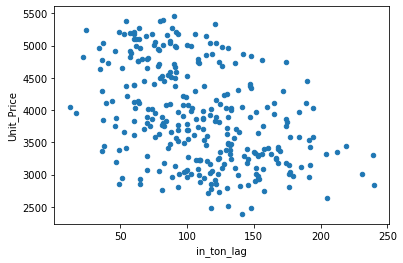

In [30]:
# 추가한 변수들과 Target과의 관계를 차트로 살펴봅시다.
data.plot(kind = 'scatter', x = 'in_ton_lag', y = 'Unit_Price')



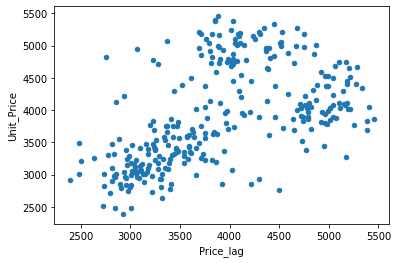

In [31]:
data.plot(kind = 'scatter', x = 'Price_lag', y = 'Unit_Price')

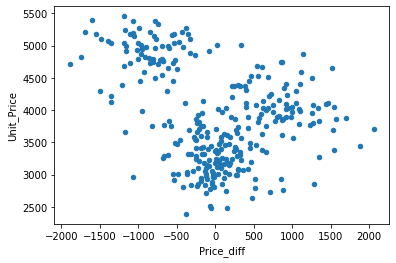

In [32]:
data.plot(kind = 'scatter', x = 'Price_diff', y = 'Unit_Price')

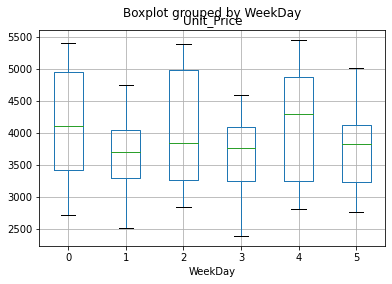

In [34]:
data.boxplot('Unit_Price', by = 'WeekDay')

## 20.데이터 준비

### 21.변수 정리

In [ ]:
# 날짜 변수는 제거합니다.


### 22.NA 처리
(아래에서 knn imputation으로 처리할 겁입니다.)

### 24.Dummy Variable

* 요일은 범주입니다. 가변수화를 수행하시오.
* 가변수화 이후 불필요한 Feature를 제거합시다.
* 주의!, 성능은 어떤 Feature를 넣느냐에 따라 달라집니다.   
* Feature가 많다고 성능이 꼭 개선되는 것은 아닙니다.

In [35]:
# dummy variable
data_wd = pd.get_dummies(data['WeekDay'] , prefix= 'W', drop_first=1)

In [36]:
data2 = pd.concat([data, data_wd], axis=1)

* 불필요한 변수를 제거합시다.

In [37]:
data.head()

,Date,ProductName,Unit_Price,Price_lag,ProductID,in_ton,in_ton_lag,WeekDay,Price_MA7,in_ton_MA7,Price_diff
0,2019-01-03,고구마,4445.0,NaN,15100,148,NaN,3,NaN,NaN,NaN
1,2019-01-04,고구마,4844.7,4445.0,15100,138,148.0,4,4445.0,148.0,NaN
2,2019-01-05,고구마,4308.5,4844.7,15100,106,138.0,5,4644.8,143.0,399.7
3,2019-01-07,고구마,5174.4,4308.5,15100,174,106.0,0,4532.7,130.7,-536.2
4,2019-01-08,고구마,4752.3,5174.4,15100,126,174.0,1,4693.2,141.5,865.9


In [38]:
# 칼럼삭제
drop_x = ['Date','ProductName','ProductID','in_ton','WeekDay']
data2.drop(drop_x, axis = 1, inplace = True)

### 25.Data Split

train : test = 7 : 3으로 분할합니다.

In [41]:
from sklearn.model_selection import train_test_split

In [39]:
X = data2.drop('Unit_Price', axis=1)
y = data2.loc[:, 'Unit_Price']

In [42]:
train_x, test_x, train_y, test_y = train_test_split(X,y, test_size = .3, random_state = 1234)

### (Again)22.NA 처리 : knn Imputation
전날 데이터를 끌어오는 작업으로 인해 NaN이 생겨 있을 것입니다.  
Knn Imputation으로 채웁시다.

In [44]:
from sklearn.impute import KNNImputer
Imputer = KNNImputer()
Imputer.fit(train_x)
train_x = Imputer.transform(train_x)
test_x = Imputer.transform(test_x)

### 26.Scaling features




In [45]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train_x)
train_x = scaler.transform(train_x)
test_x = scaler.transform(test_x)

### 27.Dataframe to Numpy array

## 30.모델링

* 알고리즘은 선형회귀, knn 둘중 무엇을 사용해도 좋습니다.
* 성능은 알고리즘, Feature 종류에 달려 있습니다. 24.에서 불필요한 변수 제거하는 부분에서 Feature를 정리할 수 있습니다.
* 모델링 평가 결과 RMSE 값을 구글 시트에 올려 봅시다.
* 1등에게는 스벅 커피 쿠폰 쏩니다.^^

In [46]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

In [50]:
model_lm = LinearRegression()
model_lm.fit(train_x, train_y)
test_pred_lm = model_lm.predict(test_x)

In [57]:
model_knn = KNeighborsRegressor(n_neighbors=3)
model_knn.fit(train_x, train_y)
test_pred_knn = model_knn.predict(test_x)

In [56]:
for k in range(2,31) :
    model_knn = KNeighborsRegressor(n_neighbors=k)
    model_knn.fit(train_x, train_y)
    test_pred_knn = model_knn.predict(test_x)
    print('k : {}, RMSE : {}'.format(k, mean_squared_error(test_y, test_pred_knn,squared=0).round(3)))

k : 2, RMSE : 414.04
k : 3, RMSE : 369.073
k : 4, RMSE : 391.585
k : 5, RMSE : 389.798
k : 6, RMSE : 396.343
k : 7, RMSE : 394.514
k : 8, RMSE : 397.444
k : 9, RMSE : 398.214
k : 10, RMSE : 389.694
k : 11, RMSE : 390.066
k : 12, RMSE : 386.106
k : 13, RMSE : 386.763
k : 14, RMSE : 393.23
k : 15, RMSE : 399.75
k : 16, RMSE : 401.158
k : 17, RMSE : 414.093
k : 18, RMSE : 430.877
k : 19, RMSE : 444.546
k : 20, RMSE : 460.393
k : 21, RMSE : 473.189
k : 22, RMSE : 488.934
k : 23, RMSE : 510.066
k : 24, RMSE : 527.434
k : 25, RMSE : 542.654
k : 26, RMSE : 562.11
k : 27, RMSE : 574.97
k : 28, RMSE : 590.233
k : 29, RMSE : 601.094
k : 30, RMSE : 615.384


In [58]:
print(mean_squared_error(test_y, test_pred_lm, squared=0))
print(mean_squared_error(test_y, test_pred_knn, squared=0))

344.3790524604767
369.0725325234661


# 여러분 정말 수고 많으셨습니다!